## GMNN2CD

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sortscore
from MakeSimilarityMatrix import MakeSimilarityMatrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import time

from sklearn.preprocessing import minmax_scale
import pandas as pd
import h5py
from models import GraphConv, AE, LP
# from utils import *
# from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [2]:
args = argparse.Namespace(
    no_cuda=False,
    seed=1,
    epochs=500,
    lr=0.01,
    weight_decay=1e-5,
    hidden=256,
    alpha=0.8,
    data=1
)

args.cuda = not args.no_cuda and torch.cuda.is_available()

In [3]:
def set_seed(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)
set_seed(args.seed, args.cuda)
# gdi, ldi, rnafeat, gl, gd = load_data(args.data, args.cuda)

In [4]:
class GNNq(nn.Module):
    def __init__(self):
        super(GNNq, self).__init__()
        self.gnnql = AE(rnafeat.shape[1], 256, args.hidden)
        self.gnnqd = AE(gdi.shape[0], 256, args.hidden)

    def forward(self, xl0, xd0):
        hl, stdl, xl = self.gnnql(gl, xl0)
        hd, stdd, xd = self.gnnqd(gd, xd0)
        return hl, stdl, xl, hd, stdd, xd

In [5]:
class GNNp(nn.Module):
    def __init__(self):
        super(GNNp, self).__init__()
        self.gnnpl = LP(args.hidden, ldi.shape[1])
        self.gnnpd = LP(args.hidden, ldi.shape[0])

    def forward(self, y0):
        yl, zl = self.gnnpl(gl, y0)
        yd, zd = self.gnnpd(gd, y0.t())
        return yl, zl, yd, zd

Dataset 1, 5-fold CV


In [6]:
def GIP(circrna_disease_matrix):
    make_sim_matrix = MakeSimilarityMatrix(circrna_disease_matrix)
    return make_sim_matrix

In [7]:
def neighborhood(feat, k):
    # print("This is neighborhood...")
    # compute C
    featprod = np.dot(feat.T, feat)
    smat = np.tile(np.diag(featprod), (feat.shape[1], 1))
    dmat = smat + smat.T - 2 * featprod
    dsort = np.argsort(dmat)[:, 1:k + 1]
    C = np.zeros((feat.shape[1], feat.shape[1]))
    for i in range(feat.shape[1]):
        for j in dsort[i]:
            C[i, j] = 1.0

    return C

In [8]:
def normalized(wmat):
    # print("This is normalized...")
    deg = np.diag(np.sum(wmat, axis=0))
    degpow = np.power(deg, -0.5)
    degpow[np.isinf(degpow)] = 0
    W = np.dot(np.dot(degpow, wmat), degpow)
    return W

In [9]:
def norm_adj(feat):
    # print("This is norm_adj...")
    C = neighborhood(feat.T, k=10)
    norm_adj = normalized(C.T * C + np.eye(C.shape[0]))
    g = torch.from_numpy(norm_adj).float()
    return g

In [10]:
def load_data(rel_matrix, cuda):
    make_sim_matrix = GIP(rel_matrix)
    # circ_gipsim_matrix, dis_gipsim_matrix = make_sim_matrix.circsimmatrix, make_sim_matrix.dissimmatrix
    rnafeat, gdi = make_sim_matrix.circsimmatrix, make_sim_matrix.dissimmatrix
    ldi = rel_matrix.copy()

    rnafeat = minmax_scale(rnafeat, axis=0)
    gdit = torch.from_numpy(gdi).float()
    ldit = torch.from_numpy(ldi).float()
    rnafeatorch = torch.from_numpy(rnafeat).float()
    gl = norm_adj(rnafeat)
    gd = norm_adj(gdi.T)
    if cuda:
        gdit = gdit.cuda()
        ldit = ldit.cuda()
        rnafeatorch = rnafeatorch.cuda()
        gl = gl.cuda()
        gd = gd.cuda()

    return gdit, ldit, rnafeatorch, gl, gd

In [11]:
def criterion(output, target, msg, n_nodes, mu, logvar):
    if msg == 'disease':
        cost = F.binary_cross_entropy(output, target)
    else:
        cost = F.mse_loss(output, target)

    KL = -0.5 / n_nodes * torch.mean(torch.sum(
        1 + 2 * logvar - mu.pow(2) - logvar.exp().pow(2), 1))
    return cost + KL

In [12]:
def train(gnnq, gnnp, xl0, xd0, y0, epoch, alpha, i):
    losspl1 = []
    losspd1 = []
    lossp1 = []
    lossq1 = []
    beta0 = 1.0
    gamma0 = 1.0
    optp = torch.optim.Adam(gnnp.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    optq = torch.optim.Adam(gnnq.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    for e in range(epoch):
        gnnq.train()

        gnnq.train()
        hl, stdl, xl, hd, stdd, xd = gnnq(xl0, xd0)
        lossql = criterion(xl, xl0,
                           "lncrna", gl.shape[0], hl, stdl)
        lossqd = criterion(xd, xd0,
                           "disease", gd.shape[0], hd, stdd)
        lossq = alpha * lossql + (1 - alpha) * lossqd + beta0 * e * F.mse_loss(
            torch.mm(hl, hd.t()), y0) / epoch
        optq.zero_grad()
        lossq1.append(lossq.item())
        lossq.backward()
        optq.step()
        gnnq.eval()
        with torch.no_grad():
            hl, _, _, hd, _, _ = gnnq(xl0, xd0)

        gnnp.train()
        yl, zl, yd, zd = gnnp(y0)
        losspl = F.binary_cross_entropy(yl, y0) + gamma0 * e * F.mse_loss(zl, hl) / epoch
        losspd = F.binary_cross_entropy(yd, y0.t()) + gamma0 * e * F.mse_loss(zd, hd) / epoch
        lossp = alpha * losspl + (1 - alpha) * losspd
        losspl1.append(losspl.item())
        losspd1.append(losspd.item())
        lossp1.append(lossp.item())
        optp.zero_grad()
        lossp.backward()
        optp.step()

        with torch.no_grad():
            yl, _, yd, _ = gnnp(y0)
        # r = pd.DataFrame(lossp1)
        # r.to_csv('./output/lossp1{}.csv'.format(i))
        # r1 = pd.DataFrame(lossq1)
        # r.to_csv('./output/lossq1{}.csv'.format(i))
        # r = pd.DataFrame(losspd1)
        # r.to_csv('./output/losspd1{}.csv'.format(i))
        # r = pd.DataFrame(losspl1)
        # r.to_csv('./output/losspl1{}.csv'.format(i))
    return alpha * yl + (1 - alpha) * yd.t()

In [17]:
 with h5py.File('./Data/circRNA_cancer/circRNA_cancer.h5', 'r') as hf:
        circrna_disease_matrix = hf['infor'][:]


In [18]:
df = pd.DataFrame(circrna_disease_matrix)

In [19]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df.values.sum()

647.0

In [21]:
index_tuple = (np.where(circrna_disease_matrix == 1))
one_list = list(zip(index_tuple[0], index_tuple[1]))
random.shuffle(one_list)
split = math.ceil(len(one_list) / 5)

all_tpr = []
all_fpr = []
all_recall = []
all_precision = []
all_accuracy = []
all_F1 = []


In [22]:
 # 5-fold start
for i in range(0, len(one_list), split):
    test_index = one_list[i:i + split]
    new_circrna_disease_matrix = circrna_disease_matrix.copy()

    for index in test_index:
        new_circrna_disease_matrix[index[0], index[1]] = 0
    roc_circrna_disease_matrix = new_circrna_disease_matrix + circrna_disease_matrix
    rel_matrix = new_circrna_disease_matrix
    circnum = rel_matrix.shape[0]
    disnum = rel_matrix.shape[1]

    gdi, ldi, rnafeat, gl, gd = load_data(rel_matrix, args.cuda)
    # print("gdi",gdi)
    # gdi = torch.tensor(gdi)
    # ldi = torch.tensor(ldi)
    # rnafeat = torch.tensor(rnafeat)
    # gl = torch.tensor(gl)
    # gd = torch.tensor(gd)

    print("load_data")

    gnnq = GNNq()
    gnnp = GNNp()
    if args.cuda:
        gnnq = gnnq.cuda()
        gnnp = gnnp.cuda()

    rel_matrix_tensor = torch.tensor(np.array(rel_matrix).astype(np.float32))
    train(gnnq, gnnp, rnafeat, gdi.t(), rel_matrix_tensor, args.epochs, 0.8, i)
    gnnq.eval()
    gnnp.eval()
    yli, _, ydi, _ = gnnp(rel_matrix_tensor)
    resi = args.alpha * yli + (1 - args.alpha) * ydi.t()
    if args.cuda:
        ymat = resi.cpu().detach().numpy()
    else:
        ymat = resi.detach().numpy()

    S = ymat
    prediction_matrix = S

C:\Users\Admin\AppData\Local\Temp\ipykernel_7248\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data


C:\Users\Admin\AppData\Local\Temp\ipykernel_7248\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data


C:\Users\Admin\AppData\Local\Temp\ipykernel_7248\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data


C:\Users\Admin\AppData\Local\Temp\ipykernel_7248\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data


C:\Users\Admin\AppData\Local\Temp\ipykernel_7248\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data


In [23]:
result = pd.DataFrame(prediction_matrix)
result

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
0,0.008741,0.006476,0.688781,0.025336,0.023262,0.102780,0.020752,0.033187,0.102780,0.006569,...,0.008791,0.007116,0.006513,0.006537,0.102851,0.007449,0.008036,0.006510,0.010453,0.007052
1,0.007363,0.004709,0.025218,0.024389,0.029653,0.101537,0.024451,0.035338,0.101476,0.004618,...,0.008802,0.005516,0.004514,0.004629,0.101543,0.005552,0.006840,0.004851,0.008522,0.006179
2,0.151338,0.027289,0.257260,0.163717,0.071086,0.119523,0.386028,0.068080,0.119396,0.026200,...,0.050460,0.145669,0.026675,0.026124,0.119680,0.029328,0.138876,0.028094,0.355439,0.152298
3,0.004723,0.003080,0.020329,0.022626,0.018507,0.100265,0.015014,0.030677,0.100267,0.002954,...,0.005806,0.003650,0.002973,0.002995,0.100271,0.003976,0.004725,0.003236,0.005188,0.003972
4,0.403434,0.402115,0.403057,0.418408,0.402515,0.500000,0.402329,0.428596,0.500000,0.401994,...,0.404433,0.402025,0.402043,0.402043,0.500000,0.402897,0.403434,0.402274,0.401799,0.402766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.403437,0.402116,0.403067,0.418416,0.402523,0.500000,0.402335,0.428610,0.500000,0.401995,...,0.404436,0.402027,0.402044,0.402044,0.500000,0.402898,0.403437,0.402275,0.401800,0.402769
510,0.007362,0.004758,0.008855,0.025414,0.013355,0.100673,0.009406,0.035580,0.100693,0.004604,...,0.010074,0.004983,0.004617,0.004695,0.100694,0.005897,0.007610,0.004949,0.015195,0.005634
511,0.007359,0.004752,0.008857,0.025411,0.013358,0.100673,0.009408,0.035569,0.100693,0.004599,...,0.010069,0.004981,0.004612,0.004690,0.100694,0.005890,0.007607,0.004944,0.015196,0.005628
512,0.403434,0.402114,0.403073,0.418408,0.402527,0.500000,0.402338,0.428602,0.500000,0.401993,...,0.404431,0.402025,0.402042,0.402042,0.500000,0.402896,0.403434,0.402273,0.401797,0.402765


In [24]:
np.savetxt("./Prediction_output/Dataset2/GMNN2CD_result_data2.csv", result, delimiter=",")

C:\Users\Admin\AppData\Local\Temp\ipykernel_13868\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data完成
(312, 40)
(312, 40)
accuracy:0.4926,recall:0.8844,precision:0.0138,F1:0.0263
roc_auc 0.8823372232589624
AUPR 0.02584852957426272
roc_auc 0.8823372232589624


C:\Users\Admin\AppData\Local\Temp\ipykernel_13868\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data完成
(312, 40)
(312, 40)
accuracy:0.4926,recall:0.8929,precision:0.0142,F1:0.0270
roc_auc 0.8910603784108513
AUPR 0.027958427540680345
roc_auc 0.8910603784108513


C:\Users\Admin\AppData\Local\Temp\ipykernel_13868\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data完成
(312, 40)
(312, 40)
accuracy:0.4924,recall:0.8717,precision:0.0131,F1:0.0251
roc_auc 0.8692472692918649
AUPR 0.022795823181624597
roc_auc 0.8692472692918649


C:\Users\Admin\AppData\Local\Temp\ipykernel_13868\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data完成
(312, 40)
(312, 40)
accuracy:0.4924,recall:0.8671,precision:0.0126,F1:0.0243
roc_auc 0.8645972950295031
AUPR 0.021182309261472167
roc_auc 0.8645972950295031


C:\Users\Admin\AppData\Local\Temp\ipykernel_13868\2984293099.py:4: RuntimeWarning: divide by zero encountered in power
  degpow = np.power(deg, -0.5)


load_data完成
(312, 40)
(312, 40)
accuracy:0.4922,recall:0.8834,precision:0.0129,F1:0.0248
roc_auc 0.8811908224205532
AUPR 0.024406765070476844
roc_auc 0.8811908224205532
均值
accuracy:0.4925,recall:0.8799,precision:0.0133,F1:0.0255
AUC:0.8777,AUPR:0.0242
runtime over, now is :
2023-09-10 14:06:27


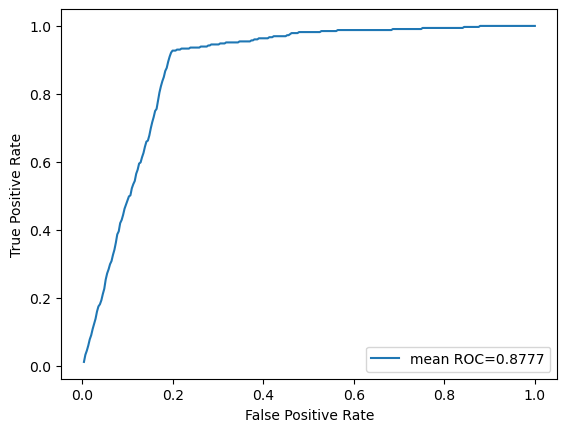

In [20]:
for i in range(0, len(one_list), split):
    test_index = one_list[i:i + split]
    new_circrna_disease_matrix = circrna_disease_matrix.copy()
    # 抹除已知关系，已知关系指的是A矩阵中值为一的节点
    for index in test_index:
        new_circrna_disease_matrix[index[0], index[1]] = 0
    roc_circrna_disease_matrix = new_circrna_disease_matrix + circrna_disease_matrix
    rel_matrix = new_circrna_disease_matrix
    circnum = rel_matrix.shape[0]
    disnum = rel_matrix.shape[1]

    ##############这里需要更改###################
    # 计算相似高斯相似矩阵
    # make_sim_matrix =GIP(rel_matrix)
    # circ_gipsim_matrix, dis_gipsim_matrix = make_sim_matrix.circsimmatrix, make_sim_matrix.dissimmatrix
    # circnum = circrna_disease_matrix.shape[0]
    # disnum = circrna_disease_matrix.shape[1]
    # SC = circ_gipsim_matrix
    # SD = dis_gipsim_matrix
    # SB = IBNP(circnum, disnum, rel_matrix)
    # # print(SB)
    # SK = KATZ(SC, SD, rel_matrix)
    # S = (SB + SK) / 2

    # rel_matrix = rel_matrix[:10][:10]
    # roc_circrna_disease_matrix = roc_circrna_disease_matrix[:10][:10]

    gdi, ldi, rnafeat, gl, gd = load_data(rel_matrix, args.cuda)
    # print("gdi",gdi)
    # gdi = torch.tensor(gdi)
    # ldi = torch.tensor(ldi)
    # rnafeat = torch.tensor(rnafeat)
    # gl = torch.tensor(gl)
    # gd = torch.tensor(gd)

    print("load_data完成")

    gnnq = GNNq()
    gnnp = GNNp()
    if args.cuda:
        gnnq = gnnq.cuda()
        gnnp = gnnp.cuda()

    rel_matrix_tensor = torch.tensor(np.array(rel_matrix).astype(np.float32))
    train(gnnq, gnnp, rnafeat, gdi.t(), rel_matrix_tensor, args.epochs, 0.8, i)
    gnnq.eval()
    gnnp.eval()
    yli, _, ydi, _ = gnnp(rel_matrix_tensor)
    resi = args.alpha * yli + (1 - args.alpha) * ydi.t()
    if args.cuda:
        ymat = resi.cpu().detach().numpy()
    else:
        ymat = resi.detach().numpy()

    S = ymat     
    prediction_matrix = S

     # giống nhau cả 3 methods
    aa = prediction_matrix.shape
    bb = roc_circrna_disease_matrix.shape
    zero_matrix = np.zeros((prediction_matrix.shape[0], prediction_matrix.shape[1]))
    print(prediction_matrix.shape)
    print(roc_circrna_disease_matrix.shape)

    score_matrix_temp = prediction_matrix.copy()
    score_matrix = score_matrix_temp + zero_matrix#标签矩阵等于预测矩阵加抹除关系的矩阵
    minvalue = np.min(score_matrix)#每列中的最小值
    score_matrix[np.where(roc_circrna_disease_matrix == 2)] = minvalue - 20#？
    sorted_circrna_disease_matrix, sorted_score_matrix, sort_index = sortscore.sort_matrix(score_matrix,roc_circrna_disease_matrix)

    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    accuracy_list = []
    F1_list = []
    for cutoff in range(sorted_circrna_disease_matrix.shape[0]):
        P_matrix = sorted_circrna_disease_matrix[0:cutoff + 1, :]
        N_matrix = sorted_circrna_disease_matrix[cutoff + 1:sorted_circrna_disease_matrix.shape[0] + 1, :]
        TP = np.sum(P_matrix == 1)
        FP = np.sum(P_matrix == 0)
        TN = np.sum(N_matrix == 0)
        FN = np.sum(N_matrix == 1)
        tpr = TP / (TP + FN)
        fpr = FP / (FP + TN)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        recall_list.append(recall)
        precision_list.append(precision)
        accuracy = (TN + TP) / (TN + TP + FN + FP)
        F1 = (2 * TP) / (2*TP + FP + FN)
        if (2*TP + FP + FN)==0 :
            F1 = 0
        F1_list.append(F1)
        accuracy_list.append(accuracy)

    # 下面是对top50，top100，top200的预测准确的计数
    # top_list = [50, 100, 200]
    # for num in top_list:
    #     P_matrix = sorted_circrna_disease_matrix[0:num, :]
    #     N_matrix = sorted_circrna_disease_matrix[num:sorted_circrna_disease_matrix.shape[0] + 1, :]
    #     top_count = np.sum(P_matrix == 1)
    #     print("top" + str(num) + ": " + str(top_count))

    ################分割线################
    tpr_arr_epoch = np.array(tpr_list)
    fpr_arr_epoch = np.array(fpr_list)
    recall_arr_epoch = np.array(recall_list)
    precision_arr_epoch = np.array(precision_list)
    accuracy_arr_epoch = np.array(accuracy_list)
    F1_arr_epoch = np.array(F1_list)
    # print("epoch,",epoch)
    print("accuracy:%.4f,recall:%.4f,precision:%.4f,F1:%.4f" % (
        np.mean(accuracy_arr_epoch), np.mean(recall_arr_epoch), np.mean(precision_arr_epoch),
        np.mean(F1_arr_epoch)))
    print("roc_auc", np.trapz(tpr_arr_epoch, fpr_arr_epoch))
    print("AUPR", np.trapz(precision_arr_epoch, recall_arr_epoch))

    # print("TP=%d, FP=%d, TN=%d, FN=%d" % (TP, FP, TN, FN))
    print("roc_auc", np.trapz(tpr_arr_epoch, fpr_arr_epoch))
    ##############分割线######################

    all_tpr.append(tpr_list)
    all_fpr.append(fpr_list)
    all_recall.append(recall_list)
    all_precision.append(precision_list)
    all_accuracy.append(accuracy_list)
    all_F1.append(F1_list)

tpr_arr = np.array(all_tpr)
fpr_arr = np.array(all_fpr)
recall_arr = np.array(all_recall)
precision_arr = np.array(all_precision)
accuracy_arr = np.array(all_accuracy)
F1_arr = np.array(all_F1)

mean_cross_tpr = np.mean(tpr_arr, axis=0)  # axis=0
mean_cross_fpr = np.mean(fpr_arr, axis=0)
mean_cross_recall = np.mean(recall_arr, axis=0)
mean_cross_precision = np.mean(precision_arr, axis=0)
mean_cross_accuracy = np.mean(accuracy_arr, axis=0)
# 计算此次五折的平均评价指标数值
mean_accuracy = np.mean(np.mean(accuracy_arr, axis=1), axis=0)
mean_recall = np.mean(np.mean(recall_arr, axis=1), axis=0)
mean_precision = np.mean(np.mean(precision_arr, axis=1), axis=0)
mean_F1 = np.mean(np.mean(F1_arr, axis=1), axis=0)
print("均值")
print("accuracy:%.4f,recall:%.4f,precision:%.4f,F1:%.4f"%(mean_accuracy, mean_recall, mean_precision, mean_F1))

roc_auc = np.trapz(mean_cross_tpr, mean_cross_fpr)
AUPR = np.trapz(mean_cross_precision, mean_cross_recall)

print("AUC:%.4f,AUPR:%.4f"%(roc_auc, AUPR))

# disease-circRNA

# GMNN2CD_circRNA_cancer_5fold_AUC
# GMNN2CD_circRNA_cancer_5fold_AUPR

# circRNADisease

# with h5py.File('./Data/circ2Traits/circRNA_disease.h5','r') as hf:
#     circrna_disease_matrix = hf['infor'][:]

# circad
# with h5py.File('./Data/circad/circrna_disease.h5', 'r') as hf:
#     circrna_disease_matrix = hf['infor'][:]
# 存储tpr，fpr,recall,precision
with h5py.File('./PlotFigure/GMNN2CD_circRNADisease_10fold_AUC.h5','w') as hf:
    hf['fpr'] = mean_cross_fpr
    hf['tpr'] = mean_cross_tpr
with h5py.File('./PlotFigure/GMNN2CD_circRNADisease_10fold_AUPR.h5','w') as h:
    h['recall'] = mean_cross_recall
    h['precision'] = mean_cross_precision

plt.plot(mean_cross_fpr, mean_cross_tpr, label='mean ROC=%0.4f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0)
plt.savefig("./FinalResultPng/roc-circRNADisease_10fold.png")
print("runtime over, now is :")
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
plt.show()


In [23]:

result = pd.DataFrame(prediction_matrix)
np.savetxt("GMNN2CD_result_2.csv", result, delimiter=",")
gmnn_matrix = np.genfromtxt('GMNN2CD_result.csv', delimiter=',')

In [25]:
are_equal = np.array_equal(prediction_matrix, gmnn_matrix)
are_equal

False

In [26]:
result

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.848806,0.051330,0.002191,0.002880,0.002582,0.003825,0.036242,0.003437,0.002398,0.003077,...,0.100236,0.002465,0.031621,0.004500,0.029773,0.025781,0.002954,0.003063,0.002393,0.002963
1,0.074503,0.773502,0.004632,0.007082,0.005299,0.008662,0.041661,0.005230,0.004052,0.004786,...,0.101279,0.004187,0.033520,0.006408,0.030954,0.030467,0.005947,0.005393,0.004052,0.004681
2,0.404963,0.403266,0.402185,0.403606,0.402849,0.401913,0.402475,0.402488,0.401608,0.402446,...,0.500000,0.401667,0.425791,0.403426,0.401995,0.401995,0.403606,0.402446,0.401633,0.402089
3,0.848544,0.051125,0.002190,0.002877,0.002580,0.003820,0.036096,0.003424,0.002389,0.003068,...,0.100236,0.002455,0.031580,0.004484,0.029671,0.025680,0.002951,0.003054,0.002384,0.002952
4,0.848785,0.051314,0.002193,0.002882,0.002584,0.003827,0.036232,0.003438,0.002399,0.003081,...,0.100236,0.002465,0.031609,0.004501,0.029769,0.025778,0.002956,0.003068,0.002394,0.002964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.091363,0.043739,0.005725,0.005998,0.006372,0.008837,0.036527,0.005100,0.003831,0.004664,...,0.100597,0.003925,0.033133,0.006395,0.763312,0.029854,0.006169,0.004952,0.003793,0.004536
308,0.867440,0.050063,0.001507,0.002381,0.001877,0.003167,0.035244,0.003081,0.002042,0.002683,...,0.100002,0.002111,0.031263,0.004172,0.025153,0.024894,0.002383,0.002683,0.002071,0.002614
309,0.848662,0.051221,0.002189,0.002877,0.002579,0.003821,0.036166,0.003428,0.002391,0.003071,...,0.100236,0.002458,0.031570,0.004489,0.029720,0.025728,0.002951,0.003058,0.002386,0.002955
310,0.030177,0.024810,0.008928,0.010428,0.010079,0.011975,0.022537,0.005576,0.004014,0.005451,...,0.100230,0.004130,0.034298,0.007124,0.019780,0.019781,0.010673,0.005109,0.004053,0.004898


In [38]:
index_tuple = (np.where(circrna_disease_matrix == 1))
one_list = list(zip(index_tuple[0], index_tuple[1]))
random.shuffle(one_list)
split = math.ceil(len(one_list) / 5)

all_tpr = []
all_fpr = []
all_recall = []
all_precision = []
all_accuracy = []
all_F1 = []

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.850357,0.050124,0.003923,0.003390,0.002835,0.003781,0.017021,0.002979,0.002978,0.002986,...,0.003297,0.002774,0.002771,0.003759,0.017010,0.003949,0.004202,0.003618,0.003120,0.100335
1,0.082882,0.754782,0.010922,0.011202,0.008810,0.014577,0.033245,0.006892,0.006836,0.007058,...,0.007796,0.007210,0.007222,0.008914,0.022906,0.012039,0.011240,0.009394,0.007096,0.103281
2,0.850059,0.049845,0.003909,0.003378,0.002825,0.003757,0.016885,0.002968,0.002967,0.002974,...,0.003284,0.002762,0.002759,0.003742,0.016924,0.003924,0.004189,0.003601,0.003110,0.100335
3,0.851377,0.050990,0.003951,0.003414,0.002851,0.003837,0.017388,0.002997,0.002997,0.003004,...,0.003319,0.002792,0.002789,0.003782,0.017224,0.004004,0.004230,0.003641,0.003137,0.100335
4,0.850246,0.050020,0.003919,0.003386,0.002829,0.003773,0.016971,0.002973,0.002972,0.002980,...,0.003291,0.002768,0.002765,0.003747,0.016979,0.003941,0.004198,0.003606,0.003115,0.100335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.046497,0.027164,0.008352,0.005925,0.003620,0.016319,0.024130,0.003634,0.003629,0.003615,...,0.004087,0.003464,0.003440,0.004504,0.782960,0.015872,0.006439,0.004210,0.004134,0.100312
308,0.870136,0.048707,0.003121,0.002785,0.002071,0.002954,0.015787,0.002480,0.002480,0.002480,...,0.003008,0.002472,0.002466,0.003207,0.011197,0.002969,0.003479,0.003197,0.002693,0.100014
309,0.850577,0.050300,0.003932,0.003398,0.002839,0.003793,0.017091,0.002984,0.002983,0.002991,...,0.003303,0.002779,0.002776,0.003763,0.017049,0.003960,0.004212,0.003622,0.003126,0.100335
310,0.014440,0.014040,0.010035,0.006815,0.002790,0.017095,0.015823,0.003279,0.003279,0.003282,...,0.003908,0.003256,0.003249,0.003898,0.024055,0.017102,0.007286,0.003906,0.004061,0.100026


In [45]:
aa = prediction_matrix.shape
bb = roc_circrna_disease_matrix.shape
zero_matrix = np.zeros((prediction_matrix.shape[0], prediction_matrix.shape[1]))
print(prediction_matrix.shape)
print(roc_circrna_disease_matrix.shape)

score_matrix_temp = prediction_matrix.copy()
score_matrix = score_matrix_temp + zero_matrix
minvalue = np.min(score_matrix)
score_matrix[np.where(roc_circrna_disease_matrix == 2)] = minvalue - 20

(312, 40)
(312, 40)


In [46]:
minvalue.real

0.0018637559842318296

In [69]:
P_matrix = np.where(prediction_matrix >= 0.50001, 1, 0)  
TP = np.sum(np.logical_and(P_matrix == 1, circrna_disease_matrix == 1))
FP = np.sum(np.logical_and(P_matrix == 1, circrna_disease_matrix == 0))
TN = np.sum(np.logical_and(P_matrix == 0, circrna_disease_matrix == 0))
FN = np.sum(np.logical_and(P_matrix == 0, circrna_disease_matrix == 1))

# Tính True Positive Rate (TPR) và False Positive Rate (FPR)
tpr = TP / (TP + FN)
fpr = FP / (FP + TN)

print(TP) 
print(FP)  
print(TN)  
print(FN)  
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)

232
0
12149
99
True Positive Rate (TPR): 0.7009063444108762
False Positive Rate (FPR): 0.0


In [70]:
P_matrix_df = pd.DataFrame(P_matrix)
sum_of_values = P_matrix_df.sum().sum()
sum_of_values

232

In [71]:
np.savetxt("GMNN2CD_test.csv", P_matrix, delimiter=",")